In [52]:
from pyrosetta import *
from pyrosetta.rosetta import *
init()

Found rosetta database at: /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database; using it....
PyRosetta-4 2017 [Rosetta PyRosetta4.Release.python27.ubuntu 2018.11+release.7c7790f7c7790fbb898f8210b54513b9f9c8a927c3e8d7f 2018-03-14T13:19:04] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Checking for fconfig files in pwd and ./rosetta/flags

core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r173 2018.11+release.7c7790f 7c7790fbb898f8210b54513b9f9c8a927c3e8d7f http://www.pyrosetta.org 2018-03-14T13:19:04
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=240418806 seed_offset=0 real_seed=240418806
core.init.random: RandomGenerator:i

In [53]:
def numerical_hessian(Es, h = 5):
    
    N = int(360/h + 1)
    d2E_dphi2 = np.zeros((N,N))
    d2E_dpsi2 = np.zeros((N,N))
    d2E_dphidpsi = np.zeros((N,N))
    r = h*np.pi/180
    
    for i in range(0, len(phis)):

        for j in range(0, len(psis)):
            
            if j == N-1:
            
                d2E_dpsi2[i,j] = (Es[i,j-1] - 2*Es[i,j] + Es[i,0])/r**2
        
            else:
            
                d2E_dpsi2[i,j] = (Es[i,j-1] - 2*Es[i,j] + Es[i,j+1])/r**2
        
    for j in range(0, len(phis)):

        for i in range(0, len(psis)):            
            if i == N-1:
            
                d2E_dphi2[i,j] = (Es[i-1,j] - 2*Es[i,j] + Es[0,j])/r**2
        
            else:
            
                d2E_dphi2[i,j] = (Es[i-1,j] - 2*Es[i,j] + Es[i+1,j])/r**2
            
    for i in range(0, len(phis)):
    
        for j in range(0, len(psis)):
        
            if j == 0:
            
                if i == 0:
                
                    d2E_dphidpsi[i,j] = Es[i+1,j+1] - Es[i+1,N-1] - Es[N-1,j+1] + Es[N-1,N-1]
            
                elif i == N-1:
                
                    d2E_dphidpsi[i,j] = Es[0,j+1] - Es[0,N-1] - Es[i-1,j+1] + Es[i-1,N-1]
                
                else:
                
                    d2E_dphidpsi[i,j] = Es[i+1,j+1] - Es[i+1,N-1] - Es[i-1,j+1] + Es[i-1,N-1]
                
            elif j == N-1:
            
                if i == 0:
                
                    d2E_dphidpsi[i,j] = Es[i+1,0] - Es[i+1,N-1] - Es[i-1,0] + Es[i-1,N-1]
            
                elif i == N-1:
                
                    d2E_dphidpsi[i,j] = Es[0,0] - Es[0,j-1] - Es[i-1,0] + Es[i-1,j-1]
                
                else:
                
                    d2E_dphidpsi[i,j] = Es[i+1,0] - Es[i+1,j-1] - Es[i-1,0] + Es[i-1,j-1]
                
            else:
            
                if i == 0:
                
                    d2E_dphidpsi[i,j] = Es[i+1,j+1] - Es[i+1,j-1] - Es[N-1,j+1] + Es[N-1,j-1]
                
                elif i == N-1:
                
                    d2E_dphidpsi[i,j] = Es[0,j+1] - Es[0,j-1] - Es[i-1,j+1] + Es[i-1,j-1]
                
                else:
                
                    d2E_dphidpsi[i,j] = Es[i+1,j+1] - Es[i+1,j-1] - Es[i-1,j+1] + Es[i-1,j-1]
                    
    return d2E_dphi2, d2E_dpsi2, d2E_dphidpsi/4/r**2

In [54]:
def get_energy_landscape(pose, scorefxn, h = 5):
    
    N = int(360/h + 1)
    residues = pose.total_residue()
    Es = np.zeros((N,N))
    
    for res in range(0, residues):
        
        phis = np.arange(-180,180+h,h)
        psis = np.arange(-180,180+h,h)

    for i in range(0,len(phis)):
    
        phi = phis[i]
        pose.set_psi(1, phi)
    
        for j in range(0,len(psis)):
            psi = psis[j]
            pose.set_omega(1, psi)
            E = scorefxn(pose)
        
            Es[i,j] = E

    return Es, phis, psis

In [55]:
def hessian(x, h):
    
    x_grad = np.gradient(x, h)
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype = x.dtype)
    
    for k, grad_k in enumerate(x_grad):
        tmp_grad = np.gradient(grad_k, h)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
            
    return hessian

In [59]:
import numpy as np
import scipy.interpolate
import random

scorefxn = get_fa_scorefxn()
pose = pose_from_pdb('alanine-dipeptide-implicit.pdb')

h = 0.5
energy, phis, psis = get_energy_landscape(pose, scorefxn, h)
#d2E_dphi2, d2E_dpsi2, d2E_dphidpsi = numerical_hessian(energy, h)
hessians = hessian(energy, h*np.pi/180)
d2E_dphi2 = hessians[0,0,:,:]
d2E_dpsi2 = hessians[1,1,:,:]
d2E_dphidpsi = hessians[0,1,:,:]
dphi2_fxn = scipy.interpolate.RectBivariateSpline(phis, psis, d2E_dphi2)
dpsi2_fxn = scipy.interpolate.RectBivariateSpline(phis, psis, d2E_dpsi2)
dphidpsis_fxn = scipy.interpolate.RectBivariateSpline(phis, psis, d2E_dphidpsi)

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.import_pose.import_pose: File 'alanine-dipeptide-implicit.pdb' automatically determined to be of type PDB
core.io.pose_from_sfr.PoseFromSFRBuilder: Renaming atom 1HH3 as 1HP2
core.io.pose_from_sfr.PoseFromSFRBuilder: Renaming atom  CH3 as  CP2
core.io.pose_from_sfr.PoseFromSFRBuilder: Renaming atom 2HH3 as 2HP2
core.io.pose_from_sfr.PoseFromSFRBuilder: Renaming atom 3HH3 as 3HP2
core.io.pose_from_sfr.PoseFromSFRBuilder: Renaming atom  C   as  CO
core.io.pose_from_sfr.PoseFromSFRBuilder: Renaming atom  O   as  OP1
core.io.pose_from_sfr.PoseFromSFRBuilder: Renaming atom  N   as  NM
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 4 atoms at position 2 in file alanine-dipeptide-implicit.pdb. Best match rsd_type:  ALA:MethylatedCtermProteinFull:AcetylatedNtermProteinFull
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CN  on residue ALA:MethylatedCtermProteinFull:AcetylatedNtermProteinFull 1
core

In [66]:
from rosetta.protocols.moves import *
from scipy.special import erf

minimum = Pose()
minimum.assign(pose)

# Set coordinates of minimum to examine
minimum.set_psi(1, -35.336)
minimum.set_omega(1, 161.966)

trial = Pose()
trial.assign(minimum)

seed = Pose()
seed_energy = 0


observer = AddPyMOLObserver(trial, True)


phi = minimum.psi(1)
psi = minimum.omega(1)

trial_energy = scorefxn(minimum)
cutoff = scorefxn(minimum) + 0.1


print phi, psi, trial_energy


hess = np.zeros((2,2))

hess[0,0] = dphi2_fxn(phi, psi)
hess[0,1] = dphidpsis_fxn(phi, psi)
hess[1,0] = hess[0,1]
hess[1,1] = dpsi2_fxn(phi, psi)

w,v = scipy.linalg.eigh(hess)

Z = 1
V = 1
Q = 1

inc = 0

print w,v 

result = 0

h = 5

for k in range(0, len(w)):
    
    mode = v[:,k]
    K = w[k]
    
    while inc < 11:
        
        inc += 1
        
        result += 0.5*np.exp(-trial_energy)

        trial.set_psi(1, trial.psi(1) - mode[0]*h)
        trial.set_omega(1, trial.omega(1) - mode[1]*h)
        
        seed_energy = scorefxn(trial)
        if seed_energy > cutoff:
            break
            
        if seed_energy < trial_energy:
            
            seed.assign(trial)
            
        trial_energy = seed_energy 
        result += 0.5*np.exp(-trial_energy)

    phi_min = trial.psi(1)
    psi_min = trial.omega(1)

    trial.assign(minimum)
    trial_energy = scorefxn(minimum)
    
    inc = 0

    while inc < 11:
    
        inc += 1
        
        result += 0.5*np.exp(-trial_energy)

        trial.set_psi(1, trial.psi(1) + mode[0]*h)
        trial.set_omega(1, trial.omega(1) + mode[1]*h)

        seed_energy = scorefxn(trial)
        if seed_energy > cutoff:
            break
            
        if seed_energy < trial_energy:
            
            seed.assign(trial)
            
        trial_energy = seed_energy 
        result += 0.5*np.exp(-trial_energy)

    result *= h*np.pi/180
    phi_max = trial.psi(1)
    psi_max = trial.omega(1)
    
    trial.assign(minimum)
    trial_energy = scorefxn(minimum)
    
    sig = np.sqrt(1.0/K)
    interval = min(6*sig, 2*np.pi/3)
    
    Q *= np.sqrt(2.0*np.pi)*sig*erf(interval/np.sqrt(2.0/K))
    
    #V *= np.pi/3
    #V *= np.sqrt(abs(phi_min-phi_max)*abs(psi_min-psi_max))*np.pi/180


    Z *= result
    result = 0

A = -np.log(Z)
print Z, A
print Q, -np.log(Q)
print 

-35.336 161.966 2.43026147777
[ 0.07755963  3.24587995] [[ 0.54835366 -0.83624653]
 [-0.83624653 -0.54835366]]
0.0149365538854 4.20394378951
5.51276144454 -1.70706566723



[-60 -55 -50 -45 -40 -35 -30 -25 -20 -15 -10  -5   0   5  10  15  20  25
  30  35  40  45  50  55  60]
[ 0.54835366 -0.83624653]


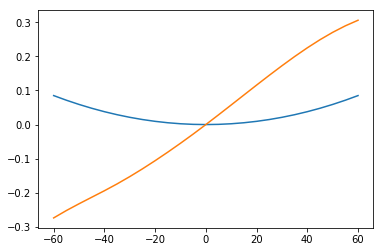

In [68]:
import matplotlib
import matplotlib.pyplot as plt

x = np.arange(-60,65,5)
print x
trial = Pose()
trial.assign(minimum)

E_0 = scorefxn(minimum)

harmonic = []
foo = []

mode = v[:,0]
K = w[0]

for xx in x:
    
    trial.set_psi(1, minimum.psi(1) + xx*mode[0])
    trial.set_omega(1, minimum.omega(1) + xx*mode[1])
    
    foo.append(scorefxn(trial)-E_0)
    harmonic.append((K*(xx*np.pi/180)**2))
    
plt.plot(x, harmonic)
plt.plot(x, foo)
print mode

In [172]:
from scipy.special import erf

Z = 1
V = 1

# Harmonic appoximation and so on and so forth 
for i in range(0, len(w)):
    
    K = w[i]
    sig = np.sqrt(1.0/K)
    interval = min(6*sig, 2*np.pi/3)
    Z *= np.sqrt(2.0*np.pi)*sig*erf(interval/np.sqrt(2.0/K))
    #V *= np.pi/3
    
print Z
    


0.38688591007


In [9]:
print seed.psi(1), seed.omega(1)

182.797922628 130.955884042


In [14]:
print -np.log(np.exp(1.313758)+np.exp(0.399378)+np.exp(0.419407))

-1.90688476694


In [67]:
print Z

0.216853617292


In [68]:
np.log(Z)

-1.5285327277592589